# Rubin Schedule Viewer

<div style="max-width:300px; float: left; margin-right: 1em">

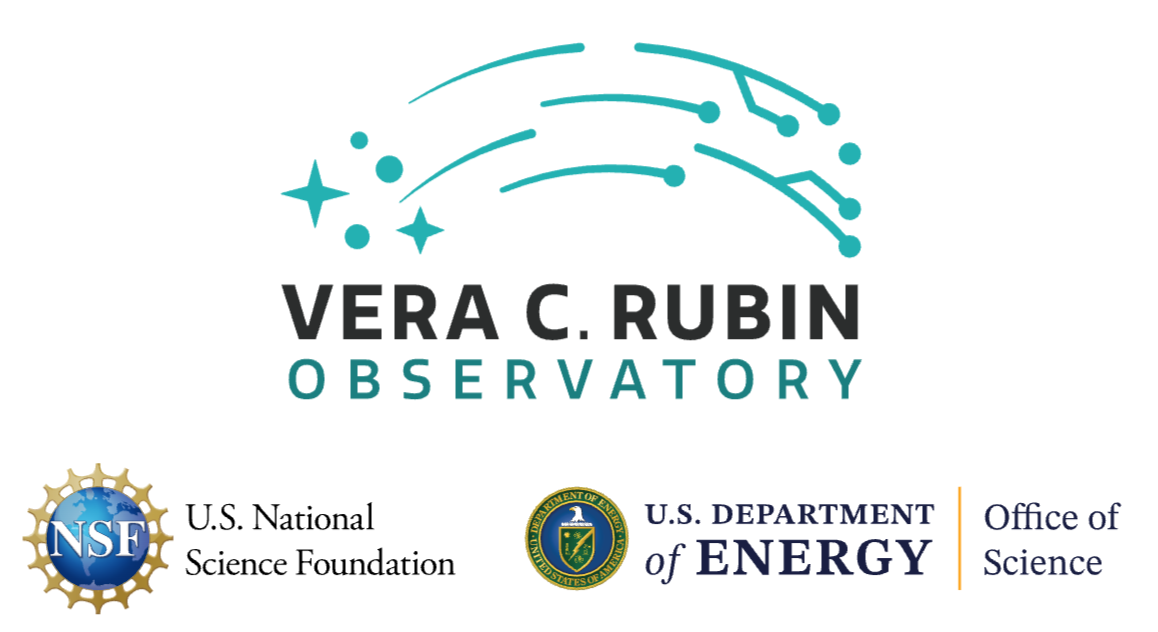

</div>

For the Rubin Science Platform at data.lsst.cloud. <br>
Container Size: Medium <br>
LSST Science Pipelines version: v29.2.0 <br>
Last verified to run: 2025-11-12 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>
DOI: <a href="https://doi.org/10.11578/rubin/dc.20250909.20">10.11578/rubin/dc.20250909.20</a> <br>

**Learning objective:** How to programmatically query the Rubin Schedule Viewer

**Rubin service:** The Rubin Schedule Viewer service runs at the USDF and is publicly available at 
<a href='https://usdf-rsp.slac.stanford.edu/obsloctap/static/viewer.html'> Rubin Schedule Viewer</a>.

**Packages:** 

**Credit:** Developed by the Rubin Community Science team. Please consider acknowledging them if this notebook 
is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

This tutorial demonstrates how to query the **Rubin Schedule Viewer**, available at: <a href="https://survey-strategy.lsst.io/progress/sv_status/sv_20250930.html">Rubin Schedule Viewer</a> 

The Rubin Schedule Viewer service publishes both the next scheduled visit and the predicted observing schedule for Rubin Observatory. 
It provides a user-friendly web interface as well as a programmatic web API, enabling the community to access up-to-date information 
for planning observations. The Rubin Schedule Viewer provides a **nominal survey schedule** at least **24 hours** in advance, 
followed by **updated schedules** published at least **2 hours** before each observing visit.


The design of the service is described in <a href="https://dmtn-263.lsst.io/">DMTN-263</a>

### 1.1 ObsLocTAP - Observation Locator Table Access Protocol

The Rubin Schedule Viewer is built using the **IVOA Observation Locator Table Access Protocol (ObsLocTAP henceforth)** standard (<a href="https://www.ivoa.net/documents/ObsLocTAP/">Salgado et al.</a>) and incorporates information from an observatory's scheduler, including both **forecasted observations** and the **historical record** of completed visits.

ObsLocTAP specifies in a standard format, services to retrieve information about planned, scheduled and performed observations of a given target (or coordinates) for a given astronomical observatory based on the existing ObsCore data model.
This standard does not describe the access to data obtained after the processing of the observational activity, as that is the goal of ObsCore
(archived observations), although the discovery could be done in a similar way. 

ObsLocTAP defines a data model for scheduled observations and a method to run queries over compliant data, using several Virtual Observatory technologies. 

### 1.2. Key columns

The ObsLocTAP data model (table schema) for the scheduled observations is defined in the `ivoa.obsplan` table -- <a href="https://www.ivoa.net/documents/ObsLocTAP/20210609/PR-ObsLocTAP-1.0-20210609.pdf">Observation Locator 
Table Access Protocol Version 1.0</a>

The database contains 28 columns in total, but these are the key columns used in this tutorial.

* `t_planning` : Time (MJD) when this observation has been added or modified into the planning log.
* `target_name` : The name of the astronomical object observed, if any.
* `obs_id` : The observation ID from the Camera.
* `s_ra` : The Right Ascension of the visit or planned observation (degrees).
* `s_dec` : The Declination of the visit or planned observation (degrees).
* `s_fov` : The diameter (bounds) of the covered region
* `s_region` : Sky region covered by the data product (expressed in ICRS frame)
* `s_resolution` : The spatial resolution of the data expressed as FWHM
* `t_min` : The start time (MJD).
* `t_max` : The stop time (MJD).
* `t_exptime` : The total exposure time = `t_max - t_min` 
* `t_resolution` : Temporal resolution
* `facility_name` : Name of the facility used for this observation e.g Rubin Simonyi, AuxTel
* `instrument_name` : Name of the instrument used for this observation e.g LSSTCam, LSSTComCam
* `t_plan_exptime` : The planned or scheduled exposure time 
* `priority` : The Priority level { 0, 1, 2}. 0 = in the target queue as the next visit
(meaning its execution is highly likely), 1 = in the 1 hour look-ahead summit queue (so likely),
2 = 24 hour pre-night simulation, meaning it is not in the summit queue and has a high degree of uncertainty. 
* `execution_status` : Execution status of the prediction: One of the following values: Planned, Scheduled, Unscheduled, Performed, Aborte
* `tracking_type` : One of the following values: Sidereal, Solar-system-object-tracking, Fixed-az-el-transit

See  <a href="https://dmtn-263.lsst.io/">DMTN-263</a> for a description of all fields in the schema. this table will be completed in time in this tutorial.

### 1.3. Import packages

Import the `requests` package to query the service and astropy's `Time` package to easily handle times and `bokeh` + `holoviews` for interactive visualization

In [1]:
import requests
import pandas as pd
import numpy as np
from astropy.time import Time

import holoviews as hv
from holoviews import opts
from bokeh.models import HoverTool
from bokeh.palettes import Turbo

import warnings

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
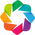

In [2]:
hv.extension("bokeh")
warnings.filterwarnings("ignore")

## 2. Rubin Schedule Viewer -- Graphical User Interface

The Rubin Schedule Viewer User Interface (UI) provides a convenient graphical user interface to query and explore the 
Rubin schedule of observations. 
It provides the facility to interactively query the historical and future schedule from a specified point in time (MJD or ISO) 
for a number of hours into the future. It provides a filter by execution status, e.g. executed or scheduled, and a 
filter by `target_name`, e.g `low-dust`, `LMC_SMC`, `dusty_plane`.

The Rubin Schedule Viewer runs at the US Data Facility at SLAC and have a publicly accessible user interface at: <a href="https://usdf-rsp.slac.stanford.edu/obsloctap/static/viewer.html">Rubin Schedule Viewer UI</a>. 

### 2.2. Inspect the Static User Interface

Go to the <a href="https://usdf-rsp.slac.stanford.edu/obsloctap/static/viewer.html">Rubin Schedule Viewer UI</a> in a new tab. In the cell below, we will programmatically check the health of the static UI.

In [3]:
rubin_static_schedule_url = (
    "https://usdf-rsp.slac.stanford.edu/obsloctap/static/viewer.html"
)
response = requests.get(rubin_static_schedule_url)
assert response.status_code == 200, f"request failed with status {response.status_code}"
print(f"Rubin Schedule Viewer at {response.url} is alive")

Rubin Schedule Viewer at https://usdf-rsp.slac.stanford.edu/obsloctap/static/viewer.html is alive


## 3. Rubin Schedule Viewer -- Programmatic Access

The service’s web page is also accessible programmatically, allowing users to extract metadata from the Schedule Viewer itself, 
including links such as the GitHub repository for the service code. The Schedule Viewer does not require authentication,
which is essential for publicly distributing the observing schedule.

### 3.1. Service URL

Define the URL of the service

In [4]:
obsloctap_url = "https://usdf-rsp-dev.slac.stanford.edu/obsloctap"

### 3.2. Inspect the service
Connect to the service file using `requests` package.

In [5]:
response = requests.get(obsloctap_url)
assert response.status_code == 200, f"request failed with status {response.status_code}"
print(f"Rubin Schedule Viewer API at {response.url} is alive")

Rubin Schedule Viewer API at https://usdf-rsp-dev.slac.stanford.edu/obsloctap/ is alive


#### 3.3.1. Query the service header information


In [6]:
headers = response.json()
assert headers is not None
meta_data = headers["metadata"]
print(meta_data.keys())
print(
    f'ObsLocTap service running at USDF for "{meta_data.get("description")}" \
with documentation at  url {meta_data.get("documentation_url")}'
)

dict_keys(['name', 'version', 'description', 'repository_url', 'documentation_url'])
ObsLocTap service running at USDF for "Look at scheduler forecast and track what was observed" with documentation at  url https://obsloctap.lsst.io


## 3.3 Retrieve the Future Schedule 

Query the Rubin Schedule Service to get the upcoming forecast for up to 24 hours in advance

Define the schedule URL

In [7]:
schedule_url = obsloctap_url + "/schedule"

In [8]:
response = requests.get(schedule_url)
assert response.status_code == 200, f"request failed with status {response.status_code}"
print(f"Rubin Schedule Forecast  at {response.url} is alive")

Rubin Schedule Forecast  at https://usdf-rsp-dev.slac.stanford.edu/obsloctap/schedule is alive


### 3.3.1 Retrieve the next 24 hours of schedule. 

This is the default behaviour, no additional parameters are needed

Default response is to return the next 24hrs of schedule

In [9]:
response = requests.get(schedule_url)
assert response.status_code == 200, f"request failed with status {response.status_code}"

Extract the list of upcoming visits as a json object and convert to a pandas dataframe

In [10]:
forward_24h_schedule = pd.DataFrame(response.json())
forward_24h_schedule.head(5)

,t_planning,target_name,obs_id,obs_collection,s_ra,s_dec,s_fov,s_region,s_resolution,t_min,...,pol_xel,facility_name,instrument_name,t_plan_exptime,category,priority,execution_status,tracking_type,rubin_rot_sky_pos,rubin_nexp
0,61014.356076,lowdust,lowdust,,83.555907,-10.082025,3.0,,0.2,61014.349131,...,0,Rubin:Simonyi,LSSTCam,30.0,Fixed,2,Scheduled,Sidereal,0.0,1
1,61014.355946,dusty_plane,dusty_plane,,109.822156,-24.820347,3.0,,0.2,61014.349001,...,0,Rubin:Simonyi,LSSTCam,30.0,Fixed,2,Not Observed,Sidereal,0.0,1
2,61014.355497,lowdust,lowdust,,76.847732,-19.027035,3.0,,0.2,61014.348553,...,0,Rubin:Simonyi,LSSTCam,30.0,Fixed,2,Scheduled,Sidereal,0.0,1
3,61014.355490,dusty_plane,dusty_plane,,105.054537,-21.541029,3.0,,0.2,61014.348546,...,0,Rubin:Simonyi,LSSTCam,30.0,Fixed,2,Not Observed,Sidereal,0.0,1
4,61014.355041,lowdust,lowdust,,79.377376,-17.028654,3.0,,0.2,61014.348097,...,0,Rubin:Simonyi,LSSTCam,30.0,Fixed,2,Scheduled,Sidereal,0.0,1


Note the values in the "Execution Status" field  are all "Scheduled"

### 3.3.3 Request only the next 2 hours or predicted schedule

Define a parameter to only retrieve the next X upcoming hours of schedule

In [11]:
params = {"time": "5"}
response = requests.get(schedule_url, params=params)
assert (
    response.url == "https://usdf-rsp-dev.slac.stanford.edu/obsloctap/schedule?time=5"
)
assert response.status_code == 200, f"request failed with status {response.status_code}"

In [12]:
next_visits = pd.DataFrame(response.json())
print(
    f"There are {len(next_visits)} visits scheduled in the next {params["time"]} hour(s)."
)

There are 0 visits scheduled in the next 5 hour(s).


### 3.4. Get a previous night's scheduled observations

A start date can also be specified that is in the past to retrieve the observations that were planned on previous nights. The date can be MJD or ISO format.

Note that, these are the observations that were scheduled for that night, they are not necessarily what was observed. n the early stages of Rubin Operations, before the LSST starts


In [13]:
params = {"time": "24", "start": "2025-10-01"}

In [14]:
response = requests.get(schedule_url, params=params)
assert response.status_code == 200, f"request failed with status {response.status_code}"
print(response.url)

https://usdf-rsp-dev.slac.stanford.edu/obsloctap/schedule?time=24&start=2025-10-01


In [15]:
next_visits_from_date = response.json()
print(
    f"There are/were {len(next_visits_from_date)} visits \
scheduled in the {params["time"]} hour(s) from {params['start']}."
)

There are/were 2198 visits scheduled in the 24 hour(s) from 2025-10-01.


In [16]:
past_time = (Time("2025-10-28 22:00:00", format="iso", scale="utc")).mjd
print(past_time)

60976.916666666664


In [17]:
params = {"time": "24", "start": past_time}

In [18]:
response = requests.get(schedule_url, params=params)
assert response.status_code == 200, f"request failed with status {response.status_code}"
print(response.url)

https://usdf-rsp-dev.slac.stanford.edu/obsloctap/schedule?time=24&start=60976.916666666664


In [19]:
next_visits_from_date_iso = pd.DataFrame(response.json())
print(
    f"There are/were {len(next_visits_from_date_iso)} visits scheduled in the \
{params["time"]} hour(s) from {Time(params['start'], format='mjd').iso}."
)

There are/were 644 visits scheduled in the 24 hour(s) from 2025-10-28 22:00:00.000.


In [20]:
next_visits_from_date_iso.head(5)

,t_planning,target_name,obs_id,obs_collection,s_ra,s_dec,s_fov,s_region,s_resolution,t_min,...,pol_xel,facility_name,instrument_name,t_plan_exptime,category,priority,execution_status,tracking_type,rubin_rot_sky_pos,rubin_nexp
0,60977.328779,lowdust,lowdust,,40.887061,-47.191258,3.0,,0.2,60977.321834,...,0,Rubin:Simonyi,LSSTCam,38.0,Fixed,2,Not Observed,Sidereal,0.0,1
1,60977.328215,lowdust,lowdust,,39.443353,-44.222025,3.0,,0.2,60977.321271,...,0,Rubin:Simonyi,LSSTCam,38.0,Fixed,2,Not Observed,Sidereal,0.0,1
2,60977.327683,lowdust,lowdust,,35.520985,-43.549164,3.0,,0.2,60977.320738,...,0,Rubin:Simonyi,LSSTCam,38.0,Fixed,2,Not Observed,Sidereal,0.0,1
3,60977.327150,lowdust,lowdust,,31.690836,-42.721862,3.0,,0.2,60977.320205,...,0,Rubin:Simonyi,LSSTCam,38.0,Fixed,2,Not Observed,Sidereal,0.0,1
4,60977.326605,lowdust,lowdust,,34.255454,-40.526152,3.0,,0.2,60977.319661,...,0,Rubin:Simonyi,LSSTCam,38.0,Fixed,2,Not Observed,Sidereal,0.0,1


Note the values in the "Execution Status" field.  They are all "Not Observed". At the time of producing this tutorial, the LSST has not started and testing at the summit is highly variable, based on the current understanding of the system. Therefore there is a very high probability that the observations scheduled are not executed. This is expected to change as we move into steady state LSST survey operations. 

In [21]:
next_visits_from_date_iso["execution_status"].unique().tolist()

['Not Observed']

## 4. Analyse the predicted schedule

In [22]:
response = requests.get(schedule_url)
df = pd.DataFrame(response.json())
print(f"There are {len(df)} visits scheduled in the next 24 hours")

There are 1152 visits scheduled in the next 24 hours


### 4.1 Look at the time gap between successive planned observations

In [23]:
# Extract t_planning values
t_planning = df["t_planning"].values

# Calculate differences between successive t_planning values (obs_visit_gap) in seconds
obs_visit_gap = []
for i in range(len(t_planning) - 1):
    diff = abs(t_planning[i] - t_planning[i + 1]) * 60 * 60 * 24
    if np.isnan(diff):
        continue
    obs_visit_gap.append(diff)

print(f"Number of differences: {len(obs_visit_gap)}")

Number of differences: 1151


In [24]:
# Create a hover tool
hover = HoverTool(
    tooltips=[("Gap Range", "@left{0.00} - @right{0.00}"), ("Count", "@top")]
)

In [25]:
# Create histogram
histogram = hv.Histogram(
    np.histogram(obs_visit_gap, bins=50), kdims="Time Gap", vdims="Counts"
).opts(
    title="Histogram of successive visit gaps for scheduled observations",
    xlabel="Gap (seconds)",
    ylabel="Count",
    width=1000,
    height=500,
    line_color="steelblue",
    fill_color="lightblue",
    line_width=1,
    show_grid=True,
    tools=["hover", "pan", "wheel_zoom", "box_zoom", "reset"],
)
histogram

:Histogram   [Time Gap]   (Counts)

In [26]:
print(f"Total observation visit gaps: {len(obs_visit_gap)}")
print(f"Min gap: {np.min(obs_visit_gap):.2f}")
print(f"Max gap: {np.max(obs_visit_gap):.2f}")
print(f"Mean gap: {np.mean(obs_visit_gap):.2f}")

Total observation visit gaps: 1151
Min gap: 0.00
Max gap: 241.91
Mean gap: 23.41


### 4.2 Time distribution of observed fields

Plot curves of the scheduled observation times per each target scheduled in the next 24 hours

In [27]:
# Get unique target names for y axis
unique_targets = df["target_name"].unique()
target_to_y = {target: i for i, target in enumerate(unique_targets)}

# Add y-axis values based on target_name
df_plot = df.copy()
df_plot["y"] = df_plot["target_name"].map(target_to_y)

# Create color map from palette with 30 colors
np.random.seed(42)
palette = list(np.random.choice(Turbo[256], len(unique_targets), replace=False))

colors = {target: palette[i % len(palette)] for i, target in enumerate(unique_targets)}

In [28]:
# Create scatter plot for each target_name
scatter_plots = []
for target in unique_targets:
    target_data = df_plot[df_plot["target_name"] == target]
    scatter = hv.Scatter(
        target_data, kdims=["t_planning"], vdims=["y", "target_name"], label=target
    )
    scatter.opts(opts.Scatter(color=colors[target]))
    scatter_plots.append(scatter)

# Combine all scatter plots
plot = hv.Overlay(scatter_plots)

# Configure hover tool
hover = HoverTool(
    tooltips=[
        ("target_name", "@{target_name}"),
        ("t_planning", "@{t_planning}{0.000000}"),
    ]
)

# Create y-axis tick labels per target names
y_ticks = [(i, target) for target, i in target_to_y.items()]

# Set all other plot options and plot
plot = plot.opts(
    opts.Scatter(
        width=1000,
        height=500,
        tools=[hover, "pan", "wheel_zoom", "box_zoom", "reset", "save"],
        xlabel="Scheduled Observation Time (MJD)",
        ylabel="Target Name",
        title="Planned Observations by Target Field over the next 24 hours",
        size=8,
        alpha=0.7,
        legend_position="right",
        legend_offset=(10, 0),
        yticks=y_ticks,
        show_legend=False,
    )
)

In [29]:
plot

:Overlay
   .Scatter.Lowdust                      :Scatter   [t_planning]   (y,target_name)
   .Scatter.Dusty_plane                  :Scatter   [t_planning]   (y,target_name)
   .Scatter.Dusty_plane_comma_lowdust    :Scatter   [t_planning]   (y,target_name)
   .Scatter.Bulgy_comma_lowdust          :Scatter   [t_planning]   (y,target_name)
   .Scatter.Dusty_plane_comma_bulgy      :Scatter   [t_planning]   (y,target_name)
   .Scatter.Euclid_overlap               :Scatter   [t_planning]   (y,target_name)
   .Scatter.Scp_comma_euclid_overlap     :Scatter   [t_planning]   (y,target_name)
   .Scatter.Bulgy                        :Scatter   [t_planning]   (y,target_name)
   .Scatter.Bulgy_comma_dusty_plane      :Scatter   [t_planning]   (y,target_name)
   .Scatter.Scp_comma_lowdust            :Scatter   [t_planning]   (y,target_name)
   .Scatter.Scp                          :Scatter   [t_planning]   (y,target_name)
   .Scatter.Lowdust_comma_scp            :Scatter   [t_planning]   (y,target_name)
   .Scatter.Scp_comma_LMC_SMC            :Scatter   [t_planning]   (y,target_name)
   .Scatter.LMC_SMC                      :Scatter   [t_planning]   (y,target_name)
   .Scatter.LMC_SMC_comma_lowdust        :Scatter   [t_planning]   (y,target_name)
   .Scatter.LMC_SMC_comma_euclid_overlap :Scatter   [t_planning]   (y,target_name)
   .Scatter.Lowdust_comma_LMC_SMC        :Scatter   [t_planning]   (y,target_name)
   .Scatter.Lowdust_comma_ddf_ecdfs      :Scatter   [t_planning]   (y,target_name)
   .Scatter.Euclid_overlap_comma_LMC_SMC :Scatter   [t_planning]   (y,target_name)
   .Scatter.Ddf_edfs_b_comma_lowdust     :Scatter   [t_planning]   (y,target_name)
   .Scatter.Lowdust_comma_ddf_edfs_b     :Scatter   [t_planning]   (y,target_name)
   .Scatter.Lowdust_comma_ddf_edfs_a     :Scatter   [t_planning]   (y,target_name)
   .Scatter.Ddf_edfs_a_comma_lowdust     :Scatter   [t_planning]   (y,target_name)
   .Scatter.Lowdust_comma_nes            :Scatter   [t_planning]   (y,target_name)
   .Scatter.Nes                          :Scatter   [t_planning]   (y,target_name)
   .Scatter.Lowdust_comma_ddf_xmm_lss    :Scatter   [t_planning]   (y,target_name)
   .Scatter.Lowdust_comma_ddf_elaiss1    :Scatter   [t_planning]   (y,target_name)
   .Scatter.Ddf_elaiss1_comma_lowdust    :Scatter   [t_planning]   (y,target_name)